# **Import needed libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# **Import Dataset**

In [2]:
df = pd.read_csv(filepath_or_buffer='Phishing_Legitimate_full.csv', header=0)
len(df)

10000

# **Preprocess Data**

**Get technical information of dataset**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

In [4]:
df.isnull().values.any()

False

In [5]:
df = df.drop(['PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT', 'PctExtNullSelfRedirectHyperlinksRT'], axis=1)


**Add the corresponding URL information to each line**

In [6]:
url_column = []

phishing_file = open("url_list_phishing_5000.txt", "r")
for line in phishing_file:
    url_column.append(line)

legitimate_file = open("url_list_legitimate_5000.txt", "r")
for line in legitimate_file:
    url_column.append(line)

df['URL'] = url_column

len(url_column)

10000

**Get Domain of every URL**

In [7]:
new_column = []    
for values in df['URL']:
    new_column.append(re.search(r'^((http|https)://)?[^(/|\s|:]*', values).group())

df['domain'] = new_column

**Get TLD of every URL -> if not possible to allocate delete the row**

In [8]:
new_column = []    
i = 1
for values in df['domain']:
    try:
        new_column.append(re.search(r'(?<=\.)[a-z]+(?=\/|$)', values).group())
    except:
        new_column.append("n/a")

df['tld'] = new_column

Preparation for WordCloud

In [9]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [10]:
df['text_tokenized'] = df.URL.map(lambda t: tokenizer.tokenize(t))

In [11]:
stemmer = SnowballStemmer("english")

In [12]:
df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])

In [13]:
df['text_sent'] = df['text_stemmed'].map(lambda l: ' '.join(l))

**Delete HttpsInHostname because it is 0 in all entries**

In [14]:
df = df.drop('HttpsInHostname', axis=1)

# **Data Analysis**

In [15]:
colors = ['#00CD00', '#EE2C2C']

**Analyse Data that includes IP-Addresses**

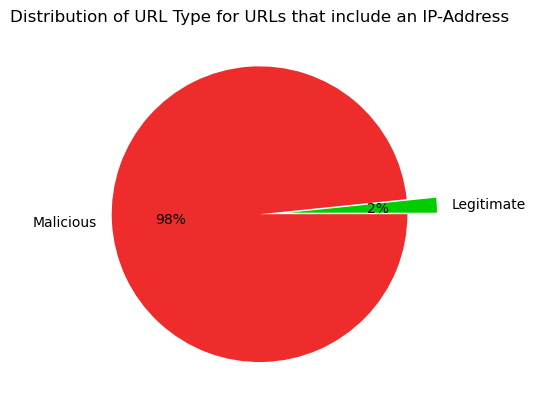

In [16]:
ip_regex = re.compile(r'\b(?:\d{1,3}\.){3}\d{1,3}\b')

df_ip = df.loc[df['URL'].str.contains(ip_regex, regex=True)]
df_ip_groupBy_label = df_ip.groupby(by=['CLASS_LABEL'],as_index = False).count()
amount_ip_addresses = df_ip_groupBy_label['URL'].sum()
df_ip_groupBy_label['Percentage'] = (df_ip_groupBy_label['URL'] / amount_ip_addresses) * 100

mylabels = ["Legitimate", "Malicious"]
myexplode = [0.2, 0]

plt.pie(df_ip_groupBy_label['URL'], labels = mylabels, colors=colors, explode = myexplode, autopct=lambda p: '{:.0f}%'.format(p))
plt.title('Distribution of URL Type for URLs that include an IP-Address')
plt.savefig('IPAddressInURL.png')
plt.show() 

The numbers show, that if a URL is including an IP-address it is very likely that the URL is malicious. Within the dataset 99,67% of all URLs that include an IP-address are malicious.

**General Distribution of Bad vs Good URLs**

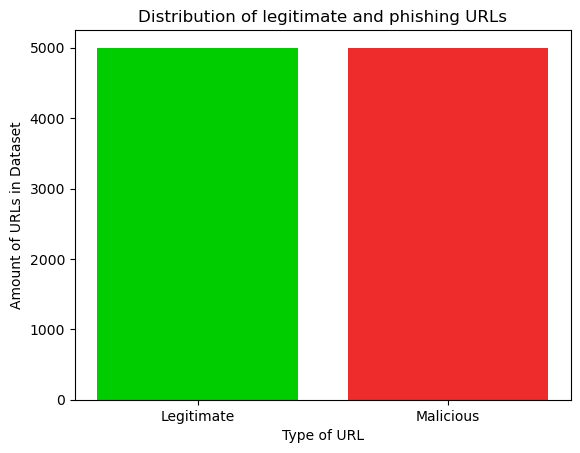

In [17]:
df_groupBy_label = df.groupby(by=['CLASS_LABEL'],as_index = False).count()
plt.bar(df_groupBy_label['CLASS_LABEL'], df_groupBy_label['id'], color=colors)
plt.xlabel('Type of URL')
plt.xticks(df_groupBy_label.index, ['Legitimate', 'Malicious'])
plt.ylabel('Amount of URLs in Dataset')
plt.title('Distribution of legitimate and phishing URLs')
plt.savefig('DistributionOfURLs.png')

**General Analysis of Data where the interquartile Range of Legitimate and Malicious URLs differ at least 10%**

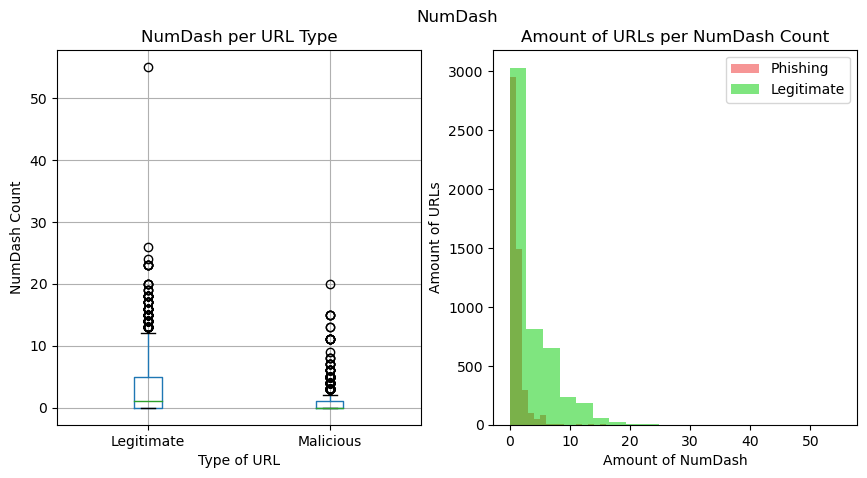

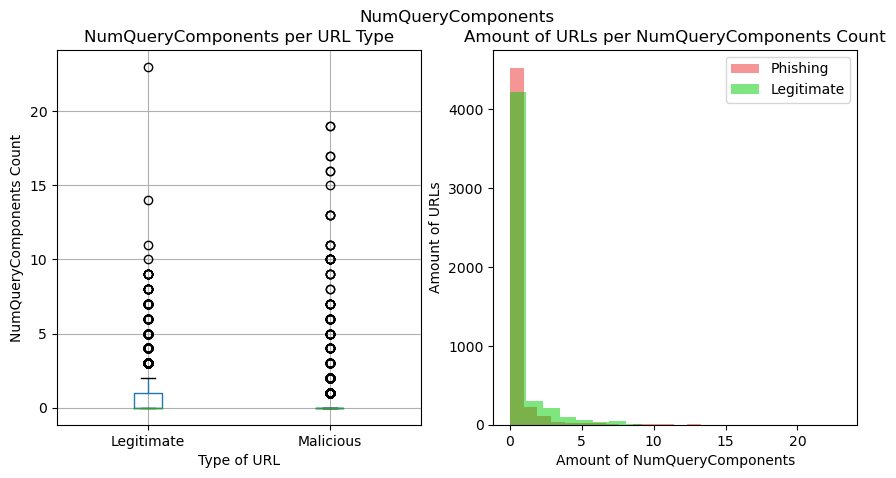

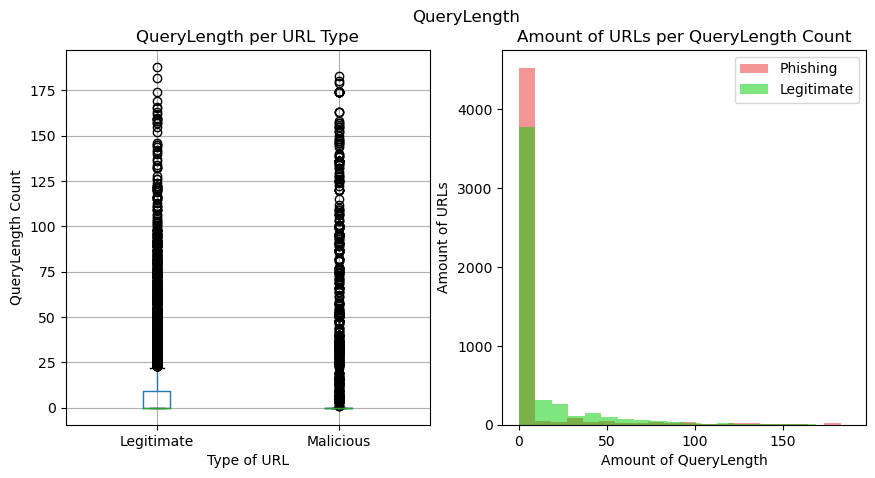

In [18]:
df_analysis = df.drop(['id'], axis=1)

df_phishing = df_analysis[df_analysis.CLASS_LABEL == 1]
df_legitimate = df_analysis[df_analysis.CLASS_LABEL == 0]

df_phishing = df_phishing.drop(['CLASS_LABEL'], axis=1)
df_legitimate = df_legitimate.drop(['CLASS_LABEL'], axis=1)

numeric_columns_phishing = df_phishing.select_dtypes(include=['int64', 'float64']).columns
numeric_columns_legitimate = df_legitimate.select_dtypes(include=['int64', 'float64']).columns
subset_phishing = df_phishing[numeric_columns_phishing]
subset_legitimate = df_legitimate[numeric_columns_legitimate]
for i, col in enumerate(subset_phishing.columns):
    q1 = subset_phishing[col].quantile(0.25)
    q3 = subset_phishing[col].quantile(0.75)
    iqr_p = q3 - q1
    q1 = subset_legitimate[col].quantile(0.25)
    q3 = subset_legitimate[col].quantile(0.75)
    iqr_l = q3 - q1
    if (iqr_p == 0 and iqr_l > 0) or (iqr_p > 0 and iqr_l > 0):
        if (iqr_p/iqr_l) > 1.5 or (iqr_p/iqr_l) < 0.5:

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

            df.boxplot(column=col, by='CLASS_LABEL', ax=ax1)
            ax1.set_xticklabels(['Legitimate', 'Malicious'])
            ax1.set_xlabel('Type of URL')
            ax1.set_ylabel(subset_phishing[col].name + ' Count')
            ax1.set_title(subset_phishing[col].name + ' per URL Type')

            ax2.hist(subset_phishing[col], bins=20, alpha=0.5, label='Phishing', color='#EE2C2C')
            ax2.hist(subset_legitimate[col], bins=20, alpha=0.5, label='Legitimate', color='#00CD00')
            ax2.set_xlabel('Amount of '+ subset_phishing[col].name)
            ax2.set_ylabel('Amount of URLs')
            ax2.set_title('Amount of URLs per ' + subset_phishing[col].name + ' Count')
            ax2.legend(loc='upper right')

            fig.suptitle(subset_phishing[col].name)

            plt.savefig('GeneralStatistics_'+subset_phishing[col].name+'.png')
            plt.show()
    elif (iqr_l == 0 and iqr_p > 0) or (iqr_p > 0 and iqr_l > 0):
        if (iqr_l/iqr_p) > 1.5 or (iqr_l/iqr_p) < 0.5:

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

            df.boxplot(column=col, by='CLASS_LABEL', ax=ax1)
            ax1.set_xticklabels(['Legitimate', 'Malicious'])
            ax1.set_xlabel('Type of URL')
            ax1.set_ylabel(subset_phishing[col].name + ' Count')
            ax1.set_title(subset_phishing[col].name + ' per URL Type')

            ax2.hist(subset_phishing[col], bins=20, alpha=0.5, label='Phishing', color='#EE2C2C')
            ax2.hist(subset_legitimate[col], bins=20, alpha=0.5, label='Legitimate', color='#00CD00')
            ax2.set_xlabel('Amount of '+ subset_phishing[col].name)
            ax2.set_ylabel('Amount of URLs')
            ax2.set_title('Amount of URLs per ' + subset_phishing[col].name + ' Count')
            ax2.legend(loc='upper right')

            fig.suptitle(subset_phishing[col].name)
            
            plt.savefig('GeneralStatistics_'+subset_phishing[col].name+'.png')
            plt.show()

**Analyse the Top-Level-Domain**

In [19]:
df_tld = df
df_tld['tld_count'] = df_tld['tld']
df_tld_groupBy_label_tld = df_tld.groupby(by=['tld', 'CLASS_LABEL'],as_index = False).count()
amount_tld = df_tld_groupBy_label_tld['tld_count'].sum()
df_tld_pivot_label_tld = df_tld_groupBy_label_tld.pivot_table('tld_count', ['tld'], 'CLASS_LABEL')
df_tld_pivot_label_tld[0] = df_tld_pivot_label_tld[0].fillna(0)
df_tld_pivot_label_tld[1] = df_tld_pivot_label_tld[1].fillna(0)
df_tld_pivot_label_tld['bad_percentage'] = (df_tld_pivot_label_tld[1] / (df_tld_pivot_label_tld[1] + df_tld_pivot_label_tld[0])) * 100
df_tld_pivot_label_tld['overall_percentage'] = ((df_tld_pivot_label_tld[1] + df_tld_pivot_label_tld[0]) / amount_tld ) * 100

df_tld_pivot_label_tld = df_tld_pivot_label_tld.sort_values(by='overall_percentage', ascending=False)

df_tld_pivot_label_tld_o05 = df_tld_pivot_label_tld[df_tld_pivot_label_tld['overall_percentage'] >= 0.5]
df_tld_pivot_label_tld_o05_sb = df_tld_pivot_label_tld_o05.sort_values('bad_percentage', ascending=False)

df_tld_pivot_label_tld_o05_sb = df_tld_pivot_label_tld_o05_sb.drop('n/a')

prices = np.array([1.17, 0, 0, 5.45, 9.69, 30.49, 9.80, 2.89, 2.44, 0.98, 4.99, 4.24, 0.98, 3.09, 8.59, 7.79, 6.39, 0, 0])
df_tld_pivot_label_tld_o05_sb  = df_tld_pivot_label_tld_o05_sb.assign(prices=prices)

152


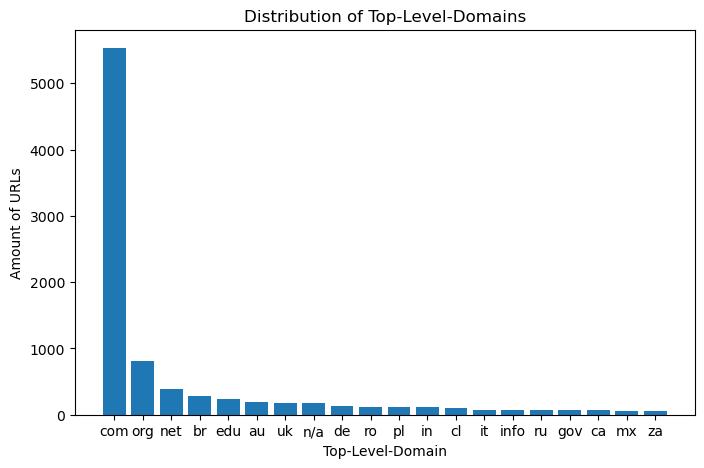

In [20]:
df_tld_groupBy_tld = df_tld_groupBy_label_tld.groupby(by=['tld'],as_index = False).sum()
print(len(df_tld_groupBy_tld))
df_tld_groupBy_tld_sort = df_tld_groupBy_tld.sort_values(by='tld_count', ascending=False)
df_tld_groupBy_tld_o20 = df_tld_groupBy_tld_sort.head(20)

plt.figure(figsize = (8, 5))
plt.bar(df_tld_groupBy_tld_o20['tld'], df_tld_groupBy_tld_o20['tld_count'])
plt.xlabel('Top-Level-Domain')
plt.ylabel('Amount of URLs')
plt.title('Distribution of Top-Level-Domains')
plt.savefig('DistributionOfTLDs.png')

In [21]:
df_tld_groupBy_tld_sort.head(5)

,tld,CLASS_LABEL,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,...,QueryLength,DoubleSlashInPath,NumSensitiveWords,EmbeddedBrandName,URL,domain,text_tokenized,text_stemmed,text_sent,tld_count
29,com,1,5533,5533,5533,5533,5533,5533,5533,5533,...,5533,5533,5533,5533,5533,5533,5533,5533,5533,5533
101,org,1,818,818,818,818,818,818,818,818,...,818,818,818,818,818,818,818,818,818,818
94,net,1,394,394,394,394,394,394,394,394,...,394,394,394,394,394,394,394,394,394,394
16,br,1,290,290,290,290,290,290,290,290,...,290,290,290,290,290,290,290,290,290,290
39,edu,0,239,239,239,239,239,239,239,239,...,239,239,239,239,239,239,239,239,239,239


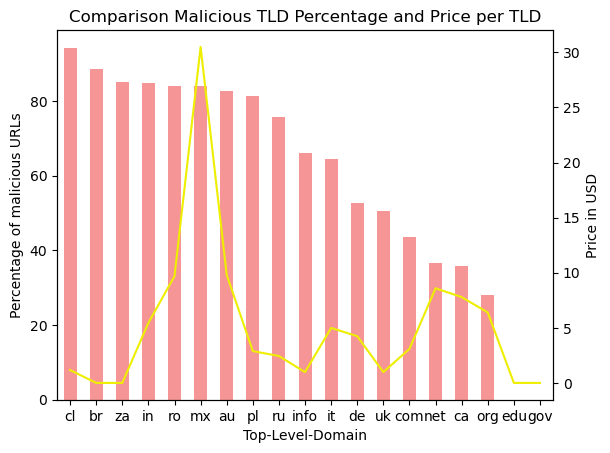

In [22]:
#df_tld_pivot_label_tld_o05.set_index('tld', inplace=True)
ax = df_tld_pivot_label_tld_o05_sb['bad_percentage'].plot(kind='bar', color='#EE2C2C', alpha=0.5)
df_tld_pivot_label_tld_o05_sb['prices'].plot(kind='line', color='#EEEE00', ax=ax, secondary_y=True)

# set axis labels and title
ax.set_ylabel('Percentage of malicious URLs')
ax.right_ax.set_ylabel('Price in USD')
ax.set_xlabel('Top-Level-Domain')
plt.title('Comparison Malicious TLD Percentage and Price per TLD')
plt.savefig('TLDUsageAndCostPercentage.png')
# display chart
plt.show()

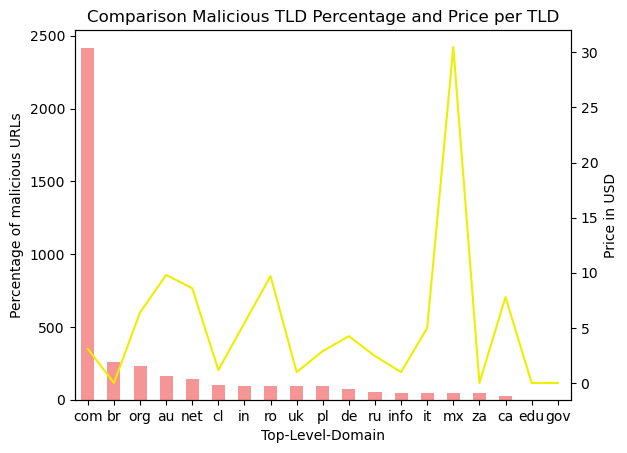

In [23]:
df_tld_pivot_label_tld_o05_sb_bad = df_tld_pivot_label_tld_o05_sb.sort_values(by=1, ascending=False)

#df_tld_pivot_label_tld_o05.set_index('tld', inplace=True)
ax = df_tld_pivot_label_tld_o05_sb_bad[1].plot(kind='bar', color='#EE2C2C', alpha=0.5)
df_tld_pivot_label_tld_o05_sb_bad['prices'].plot(kind='line', color='#EEEE00', ax=ax, secondary_y=True)

# set axis labels and title
ax.set_ylabel('Percentage of malicious URLs')
ax.right_ax.set_ylabel('Price in USD')
ax.set_xlabel('Top-Level-Domain')
plt.title('Comparison Malicious TLD Percentage and Price per TLD')
plt.savefig('TLDUsageAndCostTotal.png')
# display chart
plt.show()

Some TLDs do have a high percentage of bad urls in comparison to others -> reasons for that could be costs of tlds -> further investigation for the top 20 tlds used -> comparison of prices hard -> possible mistake URLs are from 2018 prices could vary to today

In [24]:
df_describe = df.groupby('CLASS_LABEL').describe().transpose()

**Create a correlation matrix**

C:\Users\fhupe\AppData\Local\Temp\ipykernel_20848\2625445112.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method='pearson')


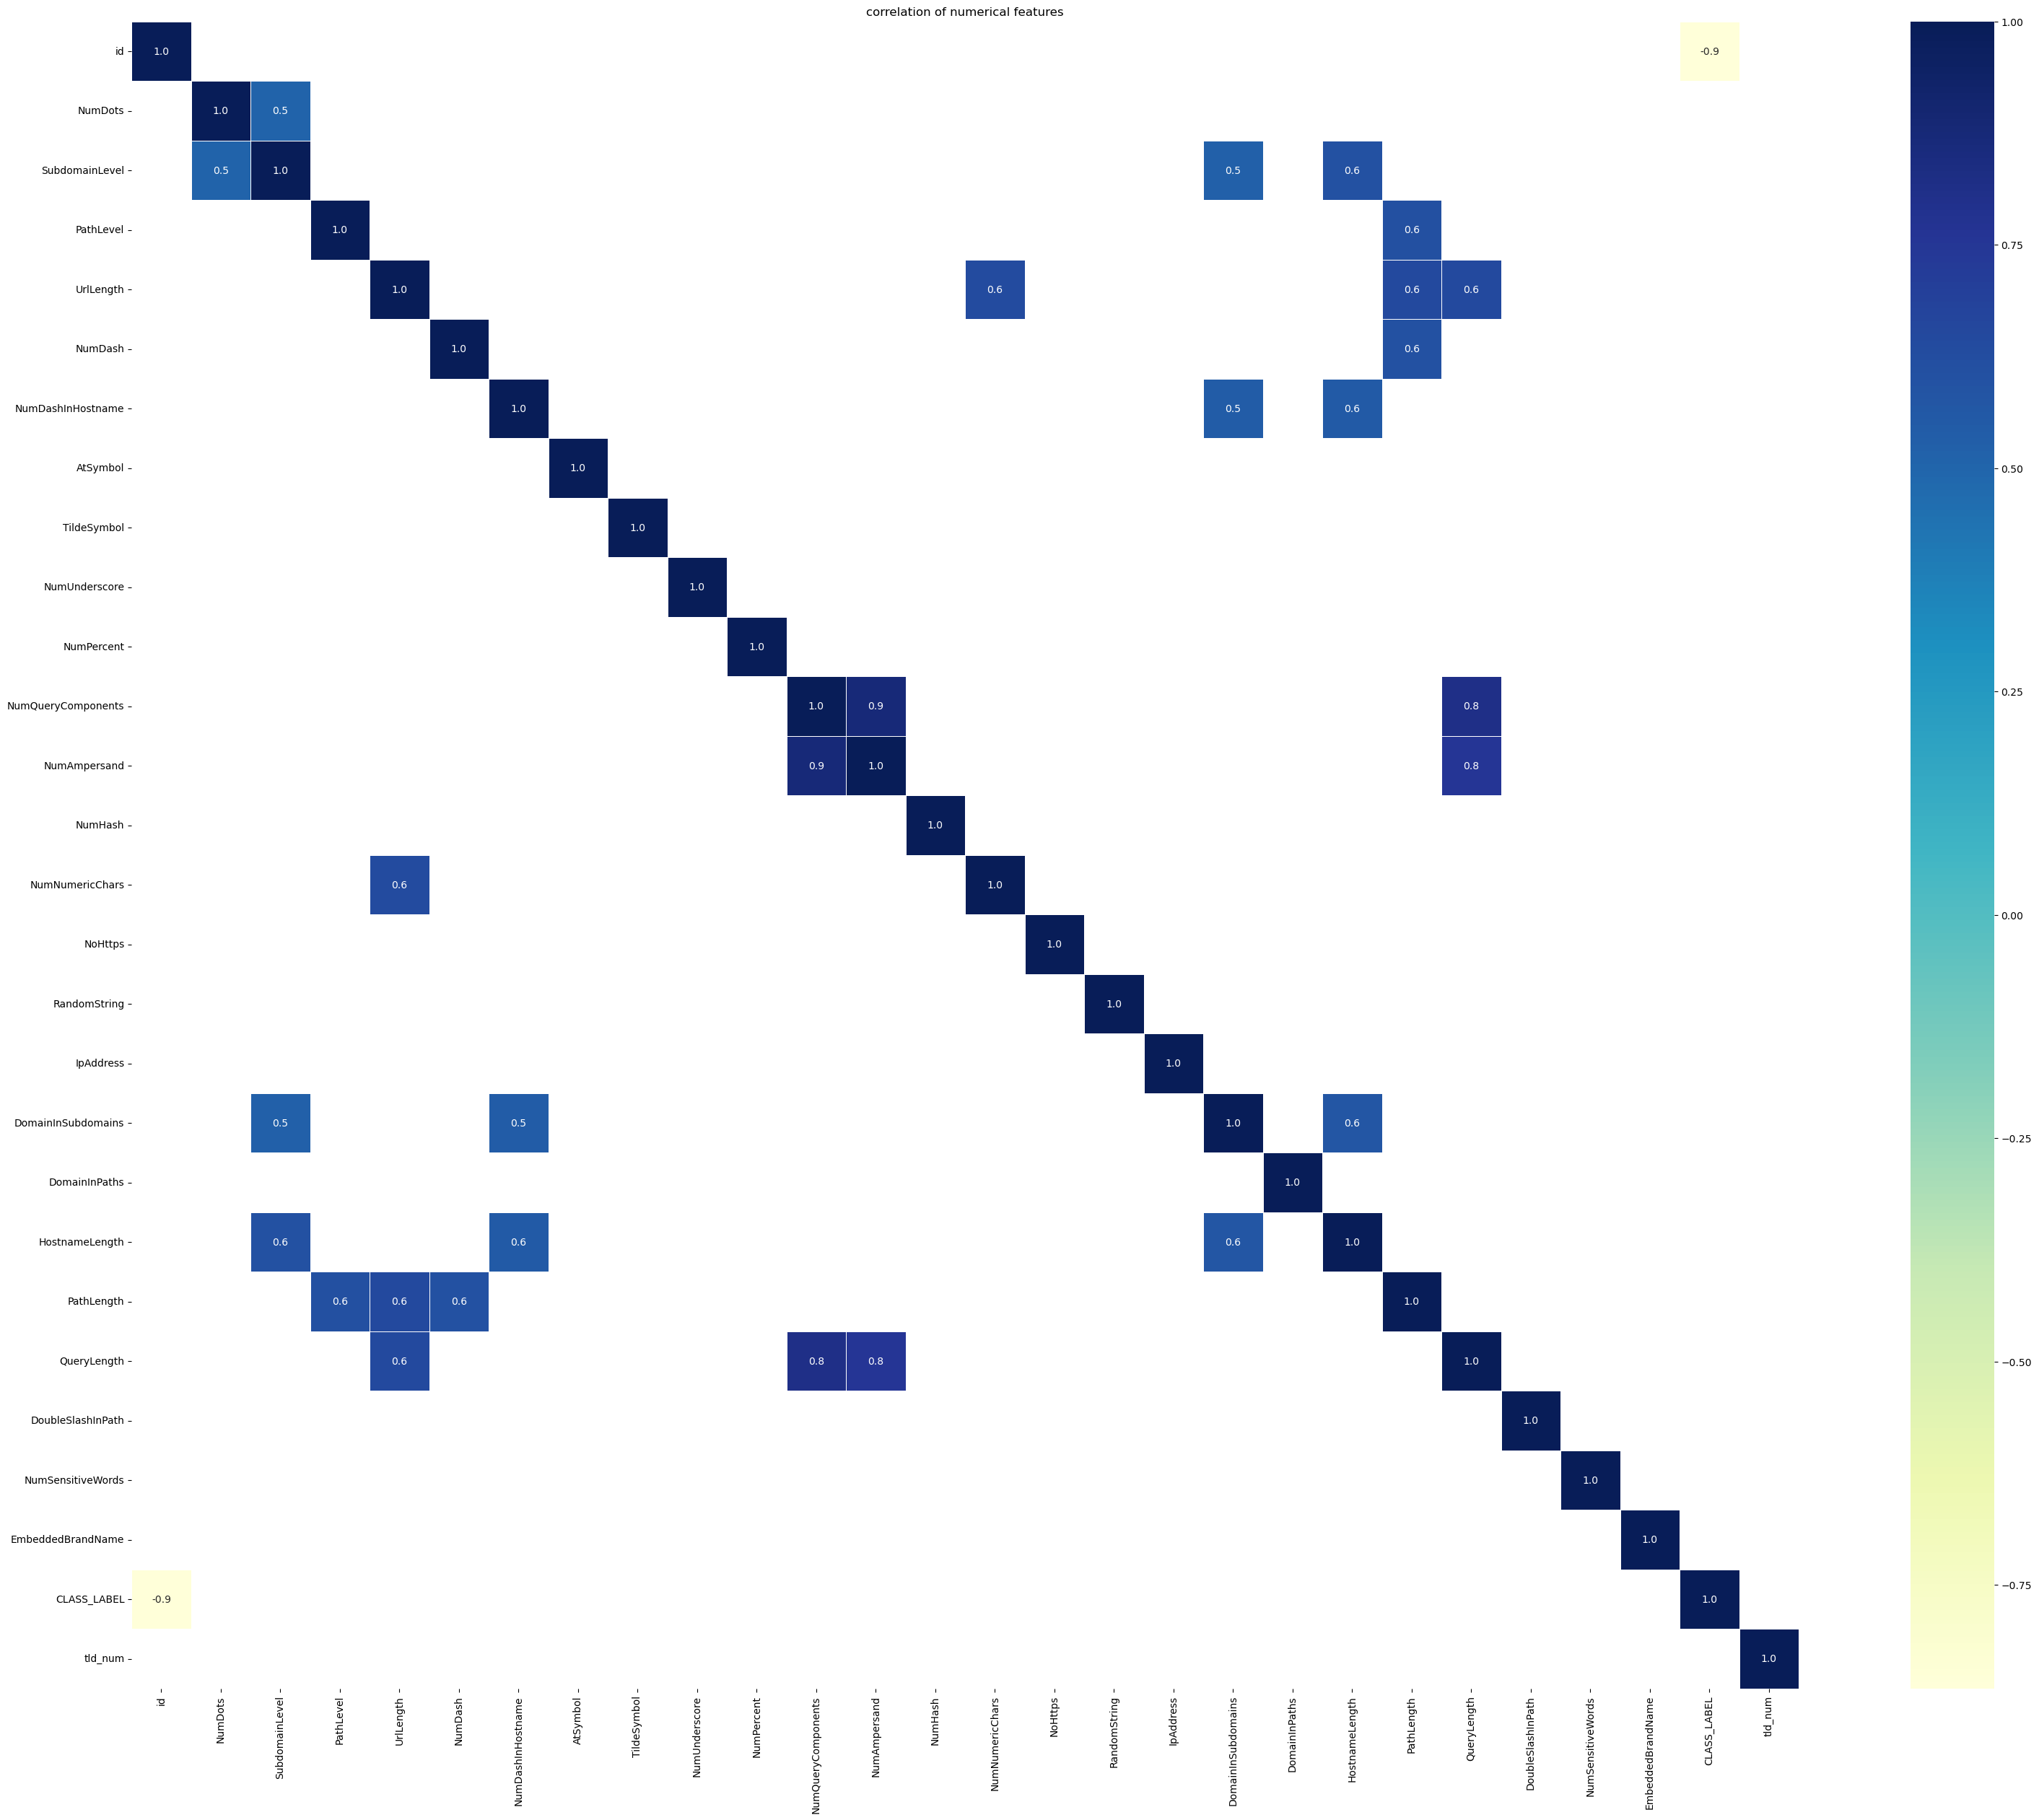

In [25]:
le = preprocessing.LabelEncoder()
df['tld_num'] = le.fit_transform(df['tld'])

plt.figure(figsize = (40, 30))
corr_matrix = df.corr(method='pearson')
filtered_matrix = corr_matrix[(corr_matrix >= 0.50) | (corr_matrix <= -0.50)]
sns.heatmap(filtered_matrix, vmax = 1, linewidths = 0.5, fmt= '.1f',
            square = True, annot = True, cmap = 'YlGnBu', linecolor = "white")
plt.title('correlation of numerical features');

**Create WordCloud**

In [26]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(8.0,6.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http','https','org','net','br','edu'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

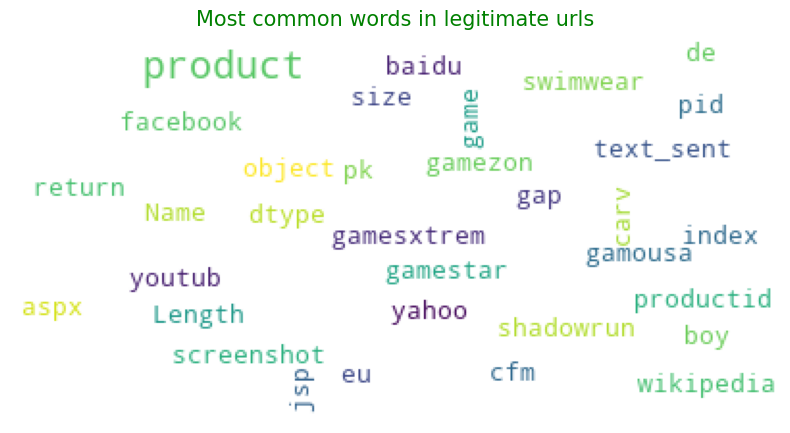

In [27]:
data = df_legitimate.text_sent
data.reset_index(drop=True, inplace=True)
common_text = str(data)
plot_wordcloud(common_text, None, max_words=400, max_font_size=20, 
               title = 'Most common words in legitimate urls', title_size=15)

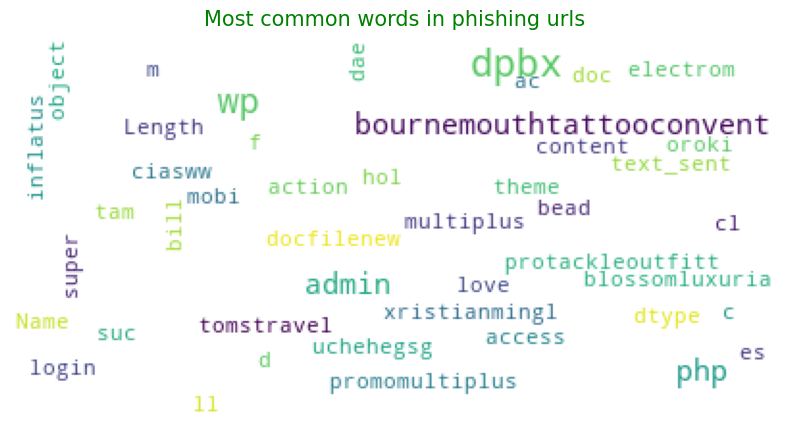

In [28]:
data = df_phishing.text_sent
data.reset_index(drop=True, inplace=True)
common_text = str(data)
plot_wordcloud(common_text, None, max_words=400, max_font_size=20, 
               title = 'Most common words in phishing urls', title_size=15)

In [29]:
pattern = r"[^\W_]+"
result = []

for values in df_phishing['URL']:

    result = np.append(result, re.findall(pattern, values))
    

# Convert the array to a DataFrame
df_words_phishing = pd.DataFrame(result)
df_words_phishing = df_words_phishing.rename(columns={0: "words"})

result = []

for values in df_legitimate['URL']:

    result = np.append(result, re.findall(pattern, values))
    

# Convert the array to a DataFrame
df_words_legitimate = pd.DataFrame(result)
df_words_legitimate = df_words_legitimate.rename(columns={0: "words"})

In [30]:
df_words_phishing["word_count"] = df_words_phishing["words"]
df_words_phishing_groupBy_words = df_words_phishing.groupby(by=['words'],as_index = False).count()
df_words_phishing_groupBy_words = df_words_phishing_groupBy_words.sort_values('word_count', ascending=False)

df_words_phishing_groupBy_words.head(20)

,words,word_count
4557,http,4915
2766,com,3389
8416,www,1876
6422,php,1535
8388,wp,1052
4554,html,941
4718,index,907
4552,htm,766
5361,login,627
2833,content,453


In [31]:
df_words_legitimate["word_count"] = df_words_legitimate["words"]
df_words_legitimate_groupBy_words = df_words_legitimate.groupby(by=['words'],as_index = False).count()
df_words_legitimate_groupBy_words = df_words_legitimate_groupBy_words.sort_values('word_count', ascending=False)

df_words_legitimate_groupBy_words.head(20)

,words,word_count
12478,http,4993
8423,com,3272
20662,www,950
12474,html,754
15808,org,607
16330,php,563
132,1,381
19229,the,329
998,2012,309
6947,blog,305


Words can be categorised if they have a majority of appearances in at least 70% of the category - Prozentangabe wie häufig wörter in klassen vorkommen

In [32]:
# Merge the two dataframes based on the "words" column
df_words_merged = pd.merge(df_words_legitimate_groupBy_words, df_words_phishing_groupBy_words, on="words", how="outer")

# Fill missing values with 0
df_words_merged = df_words_merged.fillna(0)

# Rename the columns
df_words_merged = df_words_merged.rename(columns={"word_count_x": "legitimate_count", "word_count_y": "malicious_count"})
df_words_merged["count"] = df_words_merged["legitimate_count"] + df_words_merged["malicious_count"]

# Print the result
df_words_merged.head(15)

,words,legitimate_count,malicious_count,count
0,http,4993.0,4915.0,9908.0
1,com,3272.0,3389.0,6661.0
2,www,950.0,1876.0,2826.0
3,html,754.0,941.0,1695.0
4,org,607.0,263.0,870.0
5,php,563.0,1535.0,2098.0
6,1,381.0,223.0,604.0
7,the,329.0,9.0,338.0
8,2012,309.0,9.0,318.0
9,blog,305.0,36.0,341.0


In [33]:
def classify(row):
    ratio = row["legitimate_count"] / row["count"]
    if ratio >= 0.7:
        return 0
    elif ratio < 0.7 and ratio > 0.3:
        return 99
    else:
        return 1

In [34]:
df_words_merged = df_words_merged.drop(index=df_words_merged[df_words_merged["count"] < 100].index)
df_words_merged["classification"] = df_words_merged.apply(classify, axis=1)

In [35]:
mask = df_words_merged['words'].str.match(r'^\d*$|^\D$')
df_words_merged = df_words_merged[~mask]
df_words_merged.head(50)

,words,legitimate_count,malicious_count,count,classification
0,http,4993.0,4915.0,9908.0,99
1,com,3272.0,3389.0,6661.0,99
2,www,950.0,1876.0,2826.0,99
3,html,754.0,941.0,1695.0,99
4,org,607.0,263.0,870.0,99
5,php,563.0,1535.0,2098.0,1
7,the,329.0,9.0,338.0,0
9,blog,305.0,36.0,341.0,0
10,id,268.0,154.0,422.0,99
11,net,259.0,193.0,452.0,99


In [36]:
df_words_merged = df_words_merged.drop(index=df_words_merged[df_words_merged["classification"] == 99].index)
df_words_merged.head(10)

,words,legitimate_count,malicious_count,count,classification
5,php,563.0,1535.0,2098.0,1
7,the,329.0,9.0,338.0,0
9,blog,305.0,36.0,341.0,0
12,edu,257.0,18.0,275.0,0
13,index,245.0,907.0,1152.0,1
15,page,224.0,26.0,250.0,0
16,of,219.0,1.0,220.0,0
17,news,209.0,9.0,218.0,0
18,and,203.0,0.0,203.0,0
19,to,203.0,4.0,207.0,0


In [37]:
df_words_merged.head(5)

,words,legitimate_count,malicious_count,count,classification
5,php,563.0,1535.0,2098.0,1
7,the,329.0,9.0,338.0,0
9,blog,305.0,36.0,341.0,0
12,edu,257.0,18.0,275.0,0
13,index,245.0,907.0,1152.0,1


In [38]:
df_legitimate_words = df_words_merged.loc[df_words_merged['classification'] == 0]
df_malicious_words = df_words_merged.loc[df_words_merged['classification'] == 1]

df_malicious_words.head(5)

,words,legitimate_count,malicious_count,count,classification
5,php,563.0,1535.0,2098.0,1
13,index,245.0,907.0,1152.0,1
35,htm,126.0,766.0,892.0,1
53,co,96.0,258.0,354.0,1
78,content,57.0,453.0,510.0,1


In [39]:
def count_words(text, word_list):
    count = 0
    for word in word_list:
        count += text.lower().count(word.lower())
    return count

In [40]:
# Create a list of malicious and legitimate words
malicious_words = list(df_malicious_words['words'])
legitimate_words = list(df_legitimate_words['words'])

# Count the number of occurrences of each type of word in each URL
df['malicious_word_count'] = df['URL'].apply(lambda x: count_words(x, malicious_words))
df['legitimate_word_count'] = df['URL'].apply(lambda x: count_words(x, legitimate_words))

In [41]:
df.tail(5)

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,URL,domain,tld,text_tokenized,text_stemmed,text_sent,tld_count,tld_num,malicious_word_count,legitimate_word_count
9995,9996,3,1,1,50,0,0,0,0,0,...,http://www.gamestar.de/index.cfm?pid=975&pk=33...,http://www.gamestar.de,de,"[http, www, gamestar, de, index, cfm, pid, pk]","[http, www, gamestar, de, index, cfm, pid, pk]",http www gamestar de index cfm pid pk,de,34,1,0
9996,9997,2,1,4,59,1,0,0,0,0,...,http://www.gamesxtreme.com/game/shadowrun-retu...,http://www.gamesxtreme.com,com,"[http, www, gamesxtreme, com, game, shadowrun,...","[http, www, gamesxtrem, com, game, shadowrun, ...",http www gamesxtrem com game shadowrun return ...,com,29,1,0
9997,9998,2,1,4,57,0,0,0,0,0,...,http://www.gamezone.com/products/carve/screens...,http://www.gamezone.com,com,"[http, www, gamezone, com, products, carve, sc...","[http, www, gamezon, com, product, carv, scree...",http www gamezon com product carv screenshot,com,29,2,0
9998,9999,3,1,1,49,0,0,0,0,0,...,http://www.gamousa.com/product.aspx?productID=...,http://www.gamousa.com,com,"[http, www, gamousa, com, product, aspx, produ...","[http, www, gamousa, com, product, aspx, produ...",http www gamousa com product aspx productid,com,29,3,1
9999,10000,3,1,2,52,3,0,0,0,0,...,http://www.gap.eu/products/boys-swimwear-by-si...,http://www.gap.eu,eu,"[http, www, gap, eu, products, boys, swimwear,...","[http, www, gap, eu, product, boy, swimwear, b...",http www gap eu product boy swimwear by size jsp,eu,43,2,0


C:\Users\fhupe\AppData\Local\Temp\ipykernel_20848\3758364476.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method='pearson')


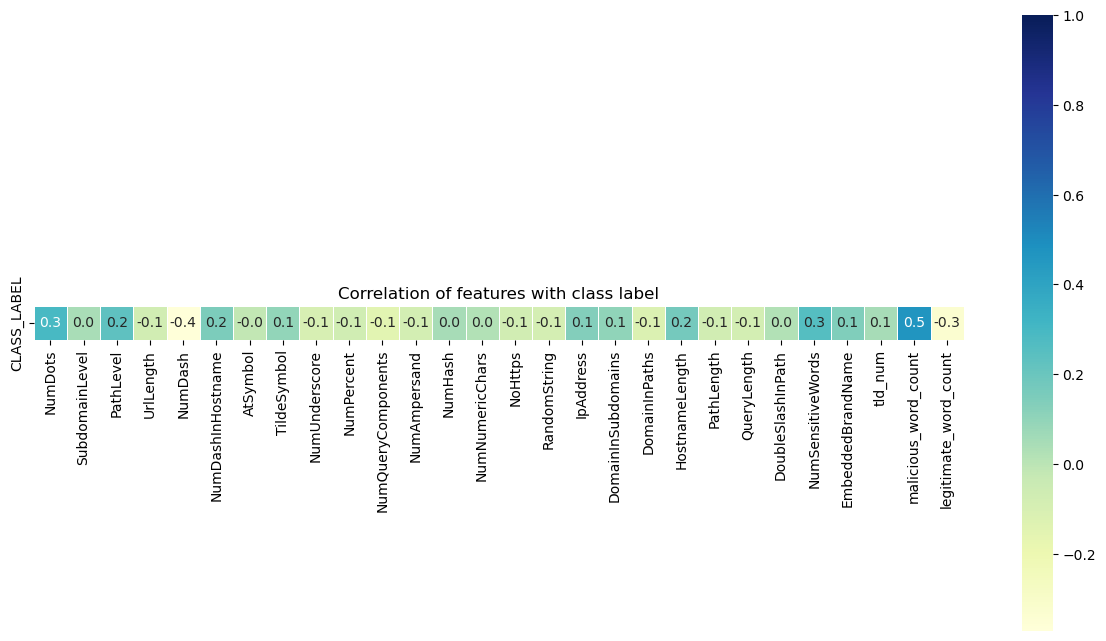

In [42]:
plt.figure(figsize = (15, 8))
corr_matrix = df.corr(method='pearson')
df_corr_class_label = corr_matrix[corr_matrix.index == 'CLASS_LABEL']

columns_df_corr_class_label = df_corr_class_label.columns
#for i, col in enumerate(columns_df_corr_class_label):
#    if df_corr_class_label[col][0] > -0.3 and df_corr_class_label[col][0] < 0.3:
#        df_corr_class_label = df_corr_class_label.drop(col, axis=1)

df_corr_class_label = df_corr_class_label.drop(['id', 'CLASS_LABEL'], axis=1)

sns.heatmap(df_corr_class_label, vmax = 1, linewidths = 0.5, fmt= '.1f',
            square = True, annot = True, cmap = 'YlGnBu', linecolor = "white")
plt.title('Correlation of features with class label');
plt.savefig('CorrelationMatrix.png')

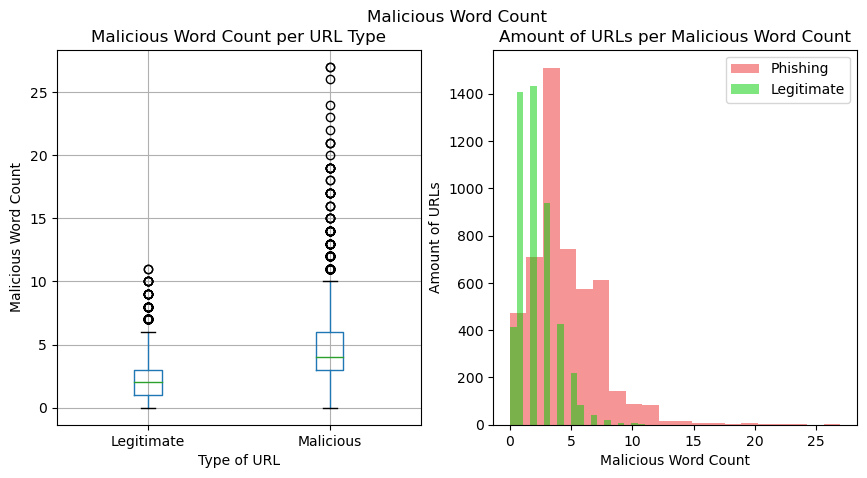

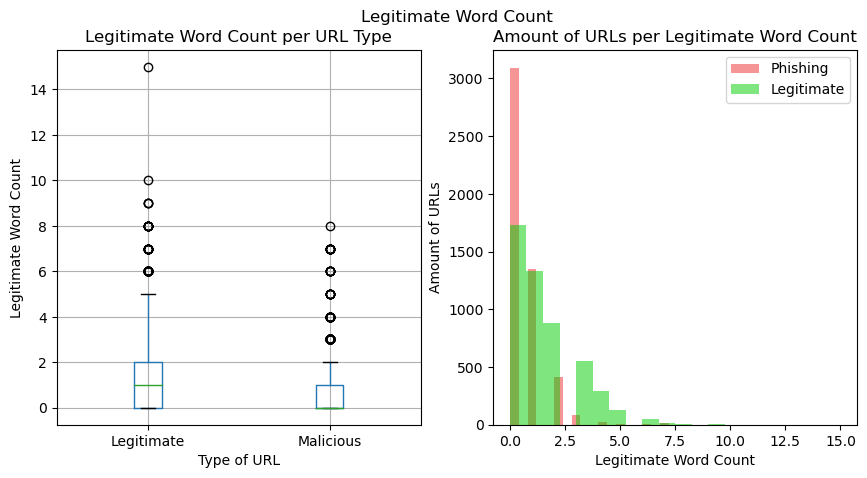

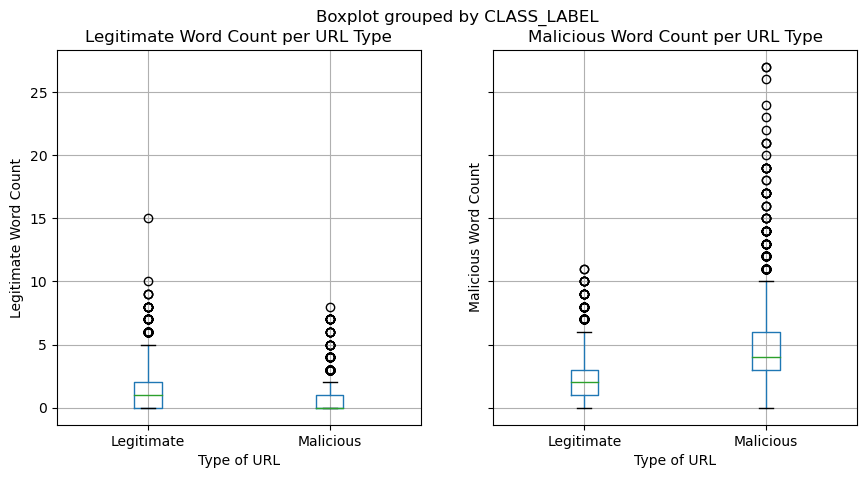

In [43]:
df_phishing = df[df.CLASS_LABEL == 1]
df_legitimate = df[df.CLASS_LABEL == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

df.boxplot(column='malicious_word_count', by='CLASS_LABEL', ax=ax1)
ax1.set_xticklabels(['Legitimate', 'Malicious'])
ax1.set_xlabel('Type of URL')
ax1.set_ylabel('Malicious Word Count')
ax1.set_title('Malicious Word Count per URL Type')

ax2.hist(df_phishing['malicious_word_count'], bins=20, alpha=0.5, label='Phishing', color='#EE2C2C')
ax2.hist(df_legitimate['malicious_word_count'], bins=20, alpha=0.5, label='Legitimate', color='#00CD00')
ax2.legend(loc='upper right')
ax2.set_xlabel('Malicious Word Count')
ax2.set_ylabel('Amount of URLs')
ax2.set_title('Amount of URLs per Malicious Word Count')

fig.suptitle('Malicious Word Count')

plt.savefig('GeneralStatistics_'+df_phishing['malicious_word_count'].name+'.png')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

df.boxplot(column='legitimate_word_count', by='CLASS_LABEL', ax=ax1)
ax1.set_xticklabels(['Legitimate', 'Malicious'])
ax1.set_xlabel('Type of URL')
ax1.set_ylabel('Legitimate Word Count')
ax1.set_title('Legitimate Word Count per URL Type')

ax2.hist(df_phishing['legitimate_word_count'], bins=20, alpha=0.5, label='Phishing', color='#EE2C2C')
ax2.hist(df_legitimate['legitimate_word_count'], bins=20, alpha=0.5, label='Legitimate', color='#00CD00')
ax2.set_xlabel('Legitimate Word Count')
ax2.set_ylabel('Amount of URLs')
ax2.set_title('Amount of URLs per Legitimate Word Count')
ax2.legend(loc='upper right')

fig.suptitle('Legitimate Word Count')

plt.savefig('GeneralStatistics_'+df_phishing['legitimate_word_count'].name+'.png')
plt.show()

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)

df.boxplot(column='legitimate_word_count', by='CLASS_LABEL', ax=ax1)

ax1.set_xticklabels(['Legitimate', 'Malicious'])

df.boxplot(column='malicious_word_count', by='CLASS_LABEL', ax=ax2)

ax2.set_xticklabels(['Legitimate', 'Malicious'])

# Add labels and title
ax1.set_xlabel('Type of URL')
ax1.set_ylabel('Legitimate Word Count')
ax1.set_title('Legitimate Word Count per URL Type')

ax2.set_xlabel('Type of URL')
ax2.set_ylabel('Malicious Word Count')
ax2.set_title('Malicious Word Count per URL Type')

plt.savefig('BoxplotsBasedOnWord.png')

# Show the plot
plt.show()

**Linear Regression**

In [44]:
df_ml = df.drop(['id', 'URL', 'domain', 'tld', 'text_tokenized', 'text_stemmed', 'text_sent', 'tld_count'], axis=1)

In [45]:
X = df_ml.drop('CLASS_LABEL', axis=1)
y = df_ml['CLASS_LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
lr = LinearRegression()

lr_model = lr.fit(X_train, y_train)

In [47]:
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# compute the evaluation metrics
mse = mean_squared_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False) #root_mean_squared_error
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# print the metrics
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R-squared:', r2)

MSE: 0.12110217362388316
RMSE: 0.3479973758864902
MAE: 0.2951673558464085
R-squared: 0.5155215406063145
